In [120]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import random
import math
%matplotlib inline

In [60]:
# Check if CUDA is available
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("Using GPU:", torch.cuda.get_device_name(0))
else:
    device = torch.device("cpu")
    print("CUDA is not available. Using CPU.")

Using GPU: NVIDIA GeForce RTX 3080 Laptop GPU


In [61]:
words = open('names.txt', 'r').read().splitlines()

In [62]:
chars = ['.'] + sorted(list(set(''.join(words))))
encode = lambda c: chars.index(c)
decode = lambda i: chars[i]

In [63]:
block_size = 3
vocab_size = len(chars)

In [64]:
def build_dataset(words):
    X, Y = [], []
    for w in words:
        context = [0] * block_size
        for c in w + '.':
            ix = encode(c)
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

random.seed(42)
random.shuffle(words)
n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xval, Yval = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [106]:
g = torch.Generator().manual_seed(2147483647)

class Linear:
    def __init__(self, fan_in, fan_out, bias=True):
        self.weight = torch.randn((fan_in, fan_out), generator=g) * (fan_in)**-0.5
        self.bias = torch.randn((fan_out), generator=g) if bias else None

    def __call__(self, x):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out
    
    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])

# batch norm
# we are using batch norm to control the statistics of the activation in the nn. 
# bn is usually applied after layers with multiplications, such as FC linear or CNN layers.
# bn has params for gain and bias, which are learnable parameters that scale and shift the output of the batch norm.
class BatchNorm1d:
    def __init__(self, dim, eps=1e-5, momentum=0.1):
        self.eps = eps
        self.momentum = momentum
        self.training = True
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)

    def __call__(self, x):
        if self.training:
            xmean = x.mean(dim=0, keepdim=True)
            xvar = x.var(dim=0, keepdim=True)
        else:
            xmean = self.running_mean
            xvar = self.running_var
        
        self.out = (x - xmean) / (xvar + self.eps).sqrt()
        self.out = self.out * self.gamma + self.beta

        if self.training:
            with torch.no_grad():
                self.running_mean = self.running_mean * (1 - self.momentum) + xmean * self.momentum
                self.running_var = self.running_var * (1 - self.momentum) + xvar * self.momentum
        
        return self.out

    def parameters(self):
        return [self.gamma, self.beta]

class Tanh:
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out

    def parameters(self):
        return []

In [110]:
n_embd = 10
n_hidden = 100

C = torch.randn((vocab_size, n_embd), generator=g)

layers = [
    Linear(n_embd*block_size, n_hidden), Tanh(),
    Linear(n_hidden, n_hidden), Tanh(),
    Linear(n_hidden, n_hidden), Tanh(),
    Linear(n_hidden, n_hidden), Tanh(),
    Linear(n_hidden, n_hidden), Tanh(),
    Linear(n_hidden, vocab_size)
]

with torch.no_grad():
    #make the laste layer less confident
    layers[-1].weight *= 0.1
    # add gain to all other layers
    for layer in layers[:-1]:
        if isinstance(layer, Linear):
            layer.weight *= 5/3

parameters = [C] + [p for layer in layers for p in layer.parameters()]

print(f"{sum(p.nelement() for p in parameters)} parameters")

for p in parameters:
    p.requires_grad = True

46497 parameters


In [111]:
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
    # make a mini batch
    ix = torch.randint(0, Xtr.shape[0], (batch_size,))
    Xb, Yb = Xtr[ix], Ytr[ix]

    # forward pass
    emb = C[Xb]
    x = emb.view(emb.shape[0], -1)
    for layer in layers:
        x = layer(x)
    loss = F.cross_entropy(x, Yb) # loss function

    # backward pass
    for layer in layers:
        layer.out.retain_grad()
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    lr = 0.1 if i < 100000 else 0.01
    for p in parameters:
        p.data -= lr * p.grad

    if i % 10000 == 0:
        print(f"{i:7d}/{max_steps:7d} {loss.item():.4f}")
    lossi.append(loss.item())

    break # Remove the break statement


      0/ 200000 3.6141


layer 1 (      Tanh): mean -0.03, std +0.80, saturated 14.66%
layer 3 (      Tanh): mean -0.03, std +0.77, saturated 10.97%
layer 5 (      Tanh): mean -0.00, std +0.72, saturated 7.62%
layer 7 (      Tanh): mean -0.00, std +0.74, saturated 9.91%
layer 9 (      Tanh): mean +0.09, std +0.71, saturated 8.69%


Text(0.5, 1.0, 'Activation distribution')

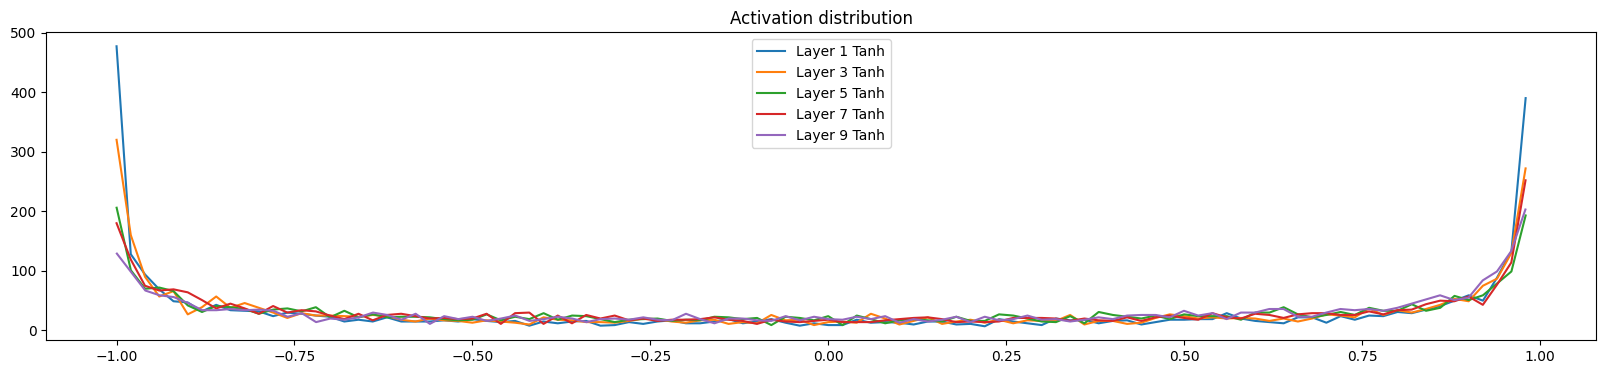

In [112]:
# visualize historgams for the forward pass
plt.figure(figsize=(20, 4))
legends = []
for i, layer in enumerate(layers):
    if isinstance(layer, Tanh):
        t = layer.out
        print(f"layer %d (%10s): mean %+.2f, std %+.2f, saturated %.2f%%" % (i, layer.__class__.__name__, t.mean(), t.std(), (t > 0.97).float().mean() * 100))
        hy, hx = torch.histogram(t.data.flatten(), bins=100)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'Layer {i} {layer.__class__.__name__}')
plt.legend(legends)
plt.title('Activation distribution')

layer 1 (      Tanh): mean -0.00, std +0.00, saturated 0.00%
layer 3 (      Tanh): mean +0.00, std +0.00, saturated 0.00%
layer 5 (      Tanh): mean +0.00, std +0.00, saturated 0.00%
layer 7 (      Tanh): mean +0.00, std +0.00, saturated 0.00%
layer 9 (      Tanh): mean +0.00, std +0.00, saturated 0.00%


Text(0.5, 1.0, 'Activation distribution')

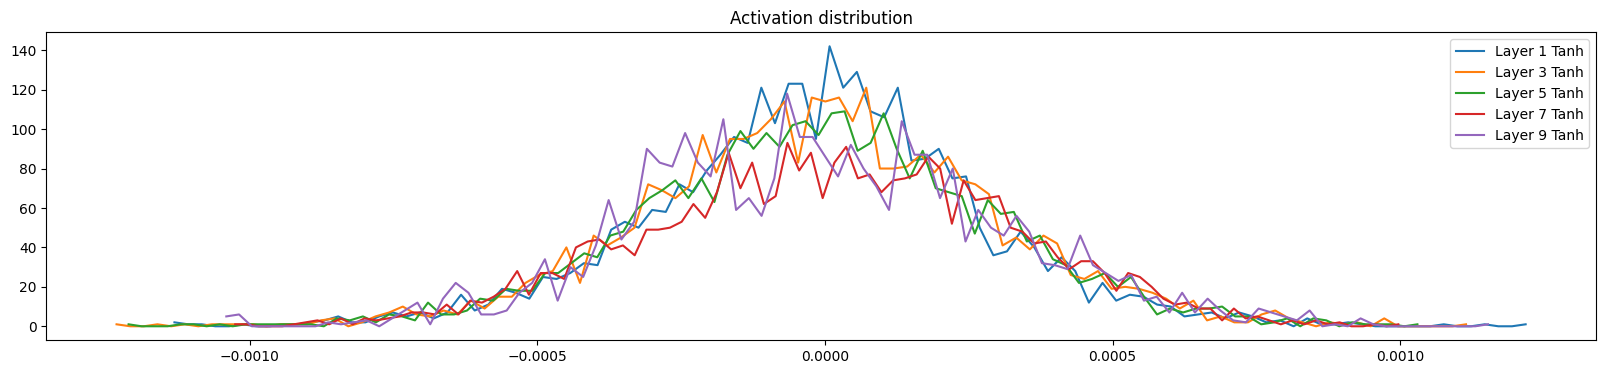

In [113]:
# visualize historgams for the backward pass
plt.figure(figsize=(20, 4))
legends = []
for i, layer in enumerate(layers):
    if isinstance(layer, Tanh):
        t = layer.out.grad
        print(f"layer %d (%10s): mean %+.2f, std %+.2f, saturated %.2f%%" % (i, layer.__class__.__name__, t.mean(), t.std(), (t > 0.9).float().mean() * 100))
        hy, hx = torch.histogram(t.data.flatten(), bins=100)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'Layer {i} {layer.__class__.__name__}')
plt.legend(legends)
plt.title('Activation distribution')

weight torch.Size([27, 10]) | mean -0.000054 | std +0.001 | grad:data ratio +2.07e-02
weight torch.Size([30, 100]) | mean +0.000023 | std +0.001 | grad:data ratio +1.88e-01
weight torch.Size([100, 100]) | mean -0.000003 | std +0.001 | grad:data ratio +2.55e-01
weight torch.Size([100, 100]) | mean -0.000002 | std +0.001 | grad:data ratio +1.34e+00
weight torch.Size([100, 100]) | mean +0.000006 | std +0.001 | grad:data ratio +2.43e+00
weight torch.Size([100, 100]) | mean -0.000008 | std +0.001 | grad:data ratio +3.45e-01
weight torch.Size([100, 27]) | mean +0.000000 | std +0.047 | grad:data ratio +3.77e+02


Text(0.5, 1.0, 'Weights gradient distribution')

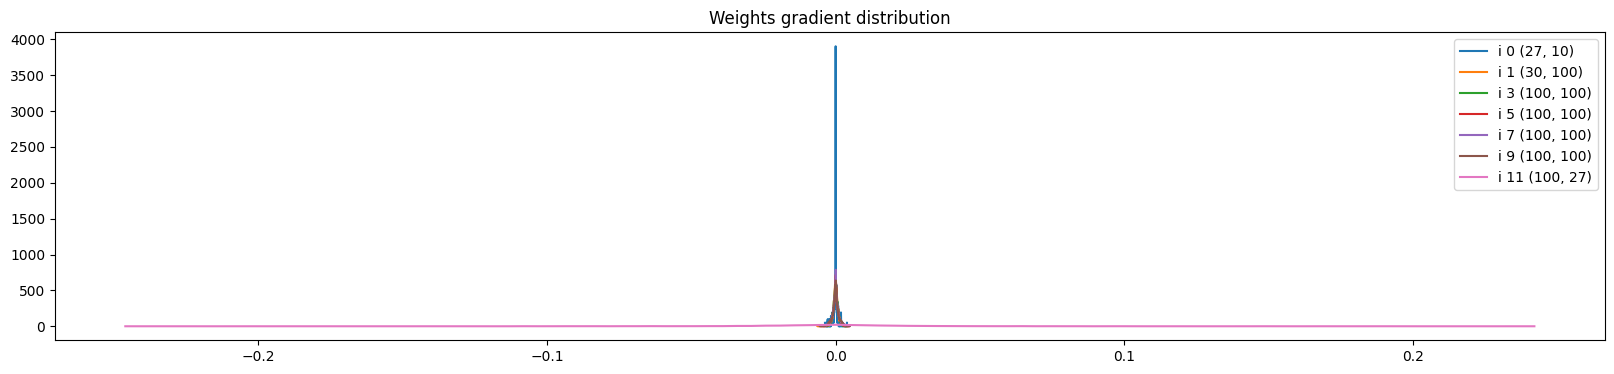

In [119]:
# visualize historgams for the backward pass
plt.figure(figsize=(20, 4))
legends = []
for i, p in enumerate(parameters):
    t = p.grad
    if p.ndim == 2:
        print(f"weight %10s | mean %+.6f | std %+.3f | grad:data ratio %+.2e" % (p.shape, t.mean(), t.std(), (t/p.data).std()))
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f"i {i} {tuple(p.shape)}")
plt.legend(legends)
plt.title('Weights gradient distribution')

In [ ]:
@torch.no_grad()
def split_loss(split):
    x, y = {
        'train': (Xtr, Ytr),
        'val': (Xval, Yval),
        'test': (Xte, Yte)
    }[split]
    emb = C[x]
    hpreact = emb.view(emb.shape[0], -1) @ W1 + b1
    hpreact = bnagin * (hpreact - bnmean_running) / bnstd_running + bnbias # we will have to keep a runnig mean and standard deviation to apply during inference
    h = torch.tanh(hpreact)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, y)
    print(f"{split} loss: {loss.item()}")

for layer in layers:
    layer.training = False

split_loss('train')
split_loss('val')

In [ ]:
for _ in range(20):
    context = [0] * block_size
    out = []
    while True:
        emb = C[torch.tensor([context])]
        h = layers[0](emb.view(1, -1))
        for layer in layers[1:]:
            h = layer(h)
        logits = h
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        context = context[1:] + [ix]
        out.append(decode(ix))
        if ix == 0:
            break
    print(''.join(out))

